**データへの確率分布の仮定**

アヤメの種類のデータ(Species)はsetosa、virginica、versicolorのいずれかに分類される→3次元のカテゴリ分布を仮定

https://www.kaggle.com/datasets/uciml/iris


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [119]:
import numpy as np
from scipy.stats import dirichlet 
import matplotlib.pyplot as plt
import pandas as pd
import ast

data = pd.read_csv("/input/Iris.csv")

# setosa=(1,0,0) virginica=(0,1,0) versicolor=(0,0,1)と置き換え
data=data.replace({'Species': {'Iris-setosa': '[1,0,0]'}})
data=data.replace({'Species': {'Iris-versicolor': '[0,1,0]'}})
data=data.replace({'Species': {'Iris-virginica': '[0,0,1]'}})

d1=len(data.query('Species == "[1,0,0]"'))
d2=len(data.query('Species == "[0,1,0]"'))
d3=len(data.query('Species == "[0,0,1]"'))
d4=len(data["Species"])

#陽性率の理論値
pi_truth_k=[d1/d4,d2/d4,d3/d4]
print(pi_truth_k)

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


**モデルの構築・学習**

カテゴリ分布のパラメータは $\sum_{k=1}^{K} \pi_{k}=1$ かつ $\pi_{k} \in(0,1)$ を取るので共役事前分布としてディリクレ分布を採用

$p(\pi)=\operatorname{Dir}(\pi \mid \alpha)$

今回は真のパラメータをもとにしたカテゴリ分布から発生したデータ系列$X_{n}$を学習させて

パラメータの事後分布を求めたいので以下のディリクレ分布を求める

$p(\pi \mid S)=\operatorname{Dir}(\pi \mid \hat{\alpha})$

$\hat{\alpha}_{k}=\sum_{n=1}^{N} s_{n, k}+\alpha_{k}$ (for $k=1, \ldots, K)$

In [120]:
# 三角座標への変換
point_vec = np.arange(0.0, 1.001, 0.02)
X, Y, Z = np.meshgrid(point_vec, point_vec, point_vec)
pi_point = np.array([list(X.flatten()), list(Y.flatten()), list(Z.flatten())]).T
pi_point = pi_point[1:, :]
pi_point /= np.sum(pi_point, axis=1, keepdims=True)
pi_point = np.unique(pi_point, axis=0)
tri_x = pi_point[:, 1] + pi_point[:, 2] / 2
tri_y = np.sqrt(3) * pi_point[:, 2] / 2
tri_x_truth = pi_truth_k[1] + pi_truth_k[2] / 2
tri_y_truth = np.sqrt(3) * pi_truth_k[2] / 2

In [131]:
# 事前分布のパラメータを指定
alpha_k = np.array([1.0, 1.0, 1.0])
N=1000
s_nk = np.random.multinomial(n=1, pvals=pi_truth_k, size=N)

# ハイパーパラメータの計算
alpha_hat_k = np.sum(s_nk, axis=0) + alpha_k
posterior = np.array([dirichlet.pdf(x=pi_point[i], alpha=alpha_hat_k) for i in range(len(pi_point))])

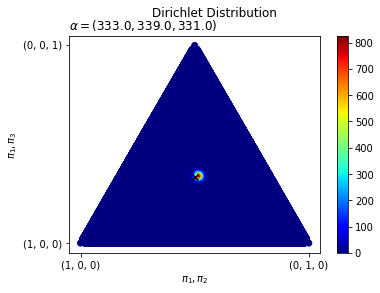

In [132]:
# 理論値と事後分布の描画
plt.figure()
plt.scatter(tri_x, tri_y, c=posterior, cmap='jet') 
plt.xlabel('$\pi_1, \pi_2$') 
plt.ylabel('$\pi_1, \pi_3$') 
plt.xticks(ticks=[0.0, 1.0], labels=['(1, 0, 0)', '(0, 1, 0)']) 
plt.yticks(ticks=[0.0, 0.87], labels=['(1, 0, 0)', '(0, 0, 1)']) 
plt.suptitle('Dirichlet Distribution')
plt.title('$\\alpha=(' + ', '.join([str(k) for k in alpha_hat_k]) + ')$', loc='left')
plt.colorbar() 
plt.gca().set_aspect('equal')
plt.scatter(tri_x_truth, tri_y_truth, marker='x', color='black')
plt.show()

**予測分布**

観測データ学習後の予測分布を得る

$\begin{aligned} p\left(\mathbf{s}_{*}\right)&=\operatorname{Cat}\left(\mathbf{s}_{*} \mid\left(\frac{\alpha_{k}}{\sum_{i=1}^{K} \alpha_{i}}\right)_{k=1}^{K}\right)\\　&=\operatorname{Cat}\left(\mathbf{s}_{*} \mid\left(\frac{\sum_{n=1}^{N} s_{n, k}+\alpha_{k}}{\sum_{i=1}^{K} (\sum_{n=1}^{N} s_{n, k}+\alpha_{k})}\right)_{k=1}^{K}\right) \end{aligned}$

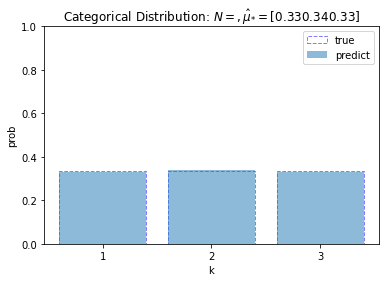

In [133]:
#予測分布の計算
pi_hat_star_k = (np.sum(s_nk, axis=0) + alpha_k) / np.sum(np.sum(s_nk, axis=0) + alpha_k)

plt.figure()
plt.bar(x=np.array([1, 2, 3]), height=pi_truth_k, label='true', alpha=0.5, color='white', edgecolor='blue', linestyle='dashed') 
plt.bar(x=np.array([1, 2, 3]), height=pi_hat_star_k, label='predict', alpha=0.5) 
plt.xlabel('k')
plt.ylabel('prob')
plt.xticks(ticks=np.array([1, 2, 3]), labels=np.array([1, 2, 3])) 
plt.title('Categorical Distribution: $N='  + ', \hat{\mu}_{*}=' + str(np.round(pi_hat_star_k, 2)) + '$')
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()

In [135]:
# 事前分布のパラメータを指定
alpha_k = np.array([1.0, 1.0, 1.0])
N=10
s_nk = np.random.multinomial(n=1, pvals=pi_truth_k, size=N)

# ハイパーパラメータの計算
alpha_hat_k = np.sum(s_nk, axis=0) + alpha_k
posterior = np.array([dirichlet.pdf(x=pi_point[i], alpha=alpha_hat_k) for i in range(len(pi_point))])

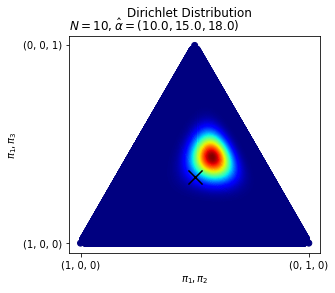

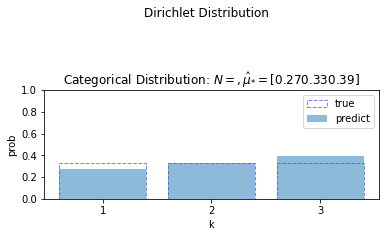

In [140]:
import matplotlib.animation as animation
s_nk = np.empty((N, 3))
alpha_hat_k = [list(alpha_k)]
posteriorList = [[dirichlet.pdf(x=pi_point[i], alpha=alpha_k) for i in range(len(pi_point))]]
p_k = alpha_k / np.sum(alpha_k)
predictList = [list(p_k)]

# 理論値と事後分布の描画
def drawPosterior(n):
    plt.cla()
    plt.scatter(tri_x, tri_y, c=posteriorList[n], cmap='jet')
    plt.scatter(tri_x_truth, tri_y_truth, marker='x', color='black', s=200)
    plt.xlabel('$\pi_1, \pi_2$')
    plt.ylabel('$\pi_1, \pi_3$')
    plt.xticks(ticks=[0.0, 1.0], labels=['(1, 0, 0)', '(0, 1, 0)']) 
    plt.yticks(ticks=[0.0, 0.87], labels=['(1, 0, 0)', '(0, 0, 1)']) 
    plt.suptitle('Dirichlet Distribution')
    plt.title('$N=' + str(n) + ', \hat{\\alpha}=(' + ', '.join([str(a) for a in alpha_hat_k[n]]) + ')$', loc='left')
    plt.gca().set_aspect('equal') 

# 理論値と予測分布の描画
def drawPredict(n):
    plt.cla()
    plt.bar(x=np.array([1, 2, 3]), height=pi_truth_k, label='true', alpha=0.5, color='white', edgecolor='blue', linestyle='dashed') 
    plt.bar(x=np.array([1, 2, 3]), height=predictList[n], label='predict', alpha=0.5) 
    plt.xlabel('k')
    plt.ylabel('prob')
    plt.xticks(ticks=np.array([1, 2, 3]), labels=np.array([1, 2, 3])) 
    plt.title('Categorical Distribution: $N='  + ', \hat{\mu}_{*}=' + str(np.round(predictList[n], 2)) + '$')  
    plt.ylim(0.0, 1.0)
    plt.legend()

for n in range(N):
    s_nk[n] = np.random.multinomial(n=1, pvals=pi_truth_k, size=1)[0]
    alpha_k += s_nk[n]
    alpha_hat_k.append(list(alpha_k))
    posteriorList.append([dirichlet.pdf(x=pi_point[i], alpha=alpha_k) for i in range(len(pi_point))])
    mu_star_k = alpha_k / np.sum(alpha_k)
    predictList.append(list(mu_star_k))
    
# gif画像の出力
posteriorAnimation = animation.FuncAnimation(plt.figure(), drawPosterior, frames=N + 1, interval=100)
posteriorAnimation.save("posteriorAnimation.gif", writer="pillow")

predictAnimation = animation.FuncAnimation(plt.figure(), drawPredict, frames=N + 1, interval=100)
predictAnimation.save("predictAnimation.gif", writer="pillow")